In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from Deep_Learning.Representation_Learning.SimCLR.model import Model
from Deep_Learning.Representation_Learning.SimCLR.train import train
from Deep_Learning.Representation_Learning.eval.mnist1k_linear import mnist1k_linear_eval

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

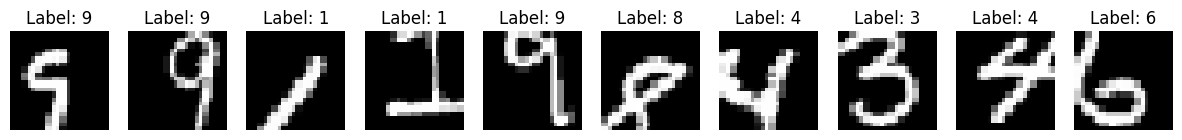

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

augmentation = transforms.Compose([
    transforms.RandomCrop(20),
    transforms.Resize(28, interpolation=transforms.InterpolationMode.NEAREST),
    # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    img = augmentation(img)
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

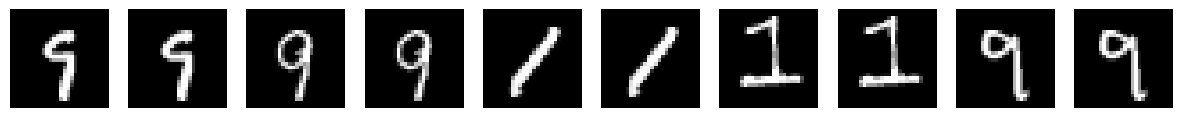

In [4]:
images = train_set.transformed_images[:5]
images = torch.cat([images, images], dim=1).view(-1, 1, 28, 28).contiguous()

fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

In [5]:
model_name = 'SimCLR'
log_dir = f'Deep_Learning/Representation_Learning/logs/{model_name}'
save_dir = f'Deep_Learning/Representation_Learning/SimCLR/models/{model_name}.pth'
# log_dir = None
# save_dir = None
writer = None
if log_dir is not None:
    writer = SummaryWriter(log_dir)
model = Model(in_features=1).to(device)

torch.Size([64, 1000])

In [6]:
to_train = True
if save_dir is not None:
    try:
        model.load_state_dict(torch.load(save_dir))
        to_train = False
    except FileNotFoundError:
        pass
        print('Model not found, training new model')
if to_train:
    train(
        model,
        train_set,
        val_set,
        num_epochs=250,
        batch_size=256,
        lr=0.001,
        wd=0.0,
        temperature=1.0,
        augmentation=augmentation,
        writer=writer,
        save_dir=save_dir,
        save_every=5,
    )

Epoch [0/250]:   0%|          | 0/188 [00:00<?, ?it/s]c:\Users\joeag\Documents\ml-learning\Deep_Learning\Representation_Learning\SimCLR\lars.py:92: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1485.)
  p.data.add_(-local_lr * group['lr'], d_p)


KeyboardInterrupt: 

In [ ]:
print("Loading Best Model")
if save_dir is not None:
    try:
        model.load_state_dict(torch.load(save_dir))
    except FileNotFoundError:
        print('Model not found')

In [ ]:
# collect 100 of each target index from train_set.targets
writer = SummaryWriter(log_dir)
mnist1k_linear_eval(model, writer)